<a href="https://colab.research.google.com/github/FrankHolzkamp/FundamentalsActiveInference/blob/main/2a_noisy_generative_process.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Noisy generative processes (Chapter 2)

Creates the plot at the beginning of Chapter 2 showing how you can add noise to a linear function to generate points normally distributed across a line.

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

*This Jupyter notebook should only be distributed to members of the "Fundamentals of Active Inference" reading group hosted by the Active Inference Institute.*

Package versions:
* matplotlib==3.5.3
* numpy==1.21.5
* pandas==1.5.1
* pyro-ppl==1.8.4
* pytorch==1.13.1

In [3]:
%matplotlib inline

In [4]:
pip install pyro-ppl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 745.2/745.2 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 33.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 50.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 781.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [5]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

import pandas as pd
import torch

from pyro.distributions import Normal

mpl.style.use("seaborn-deep")

<ipython-input-5-baf33d6799ba>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use("seaborn-deep")


## Define the environment and helper functions

First, generate 49 observations from the generative process by using the generating function $y = 2x+3$. The environment is defined in the example such that we have a number of different possible states the environment can be in (defined by `x_true`) and noise will be added to it with `y = Normal(loc=mu, scale=noise)`, where `mu` is the particular true state.

Most of the details in this plot are explained later in Chapter 2, particularly in the notebook `2b_linear_generating_functions.ipynb`.

**Note**: 49 points are chosen because later we make use of the `np.median()` function and we want an odd number of points so we can select a single value for the median.

In [6]:
# Define the generating function
def G(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

# Define the inverse generating function which can return the original state that generated the observation
def G_inv(y, beta_0, beta_1):
    x = (y - beta_0) / beta_1
    return x

# Define the sampling process
def environment(n, x_range, noise, beta_0, beta_1):
    np.random.seed(4932)
    x_true = np.random.choice(x_range, size=n)
    y_i = []
    x_i = []
    for state in x_true:
        mu = G(state, beta_0=3, beta_1=2)
        y = Normal(loc=mu, scale=noise).sample()
        x_i.append(state.tolist())
        y_i.append(y.tolist())
    return y_i, x_i

# Helper function to retreive y from input x based on sampled data points
def x_y_mapping(x ,y, x_val):
    samples = pd.DataFrame({
        "x": x, "y": y
    })

    return samples[samples["x"] == x_val]["y"].values[0]

## Generate the data to plot

In [7]:
# Define the grid (the range of values x can take)
x_range = torch.linspace(start=0.01, end=5, steps=500)

# Define standard deviation of noise
noise=1

# Generate the data and states (y, x)
data, states = environment(
    n=49,
    x_range=x_range,
    noise=noise,
    beta_0=3,
    beta_1=2)

# Generate the distribution around noise
point_x = np.median(states)     # x coordinate of a chosen sampled point
y_mean = G(point_x, beta_0=3, beta_1=2)   # y coordinate at chosen sampled point
y_range = torch.linspace(start=0.01, end=12, steps=500)
norm_cdf = Normal(y_mean, noise).cdf(y_range).tolist()
norm_pdf = np.diff(norm_cdf) / (y_range[1] - y_range[0])   # PDF = derivative of CDF
norm_pdf[norm_pdf == 0] = np.nan
norm_pdf = np.append(norm_pdf.numpy(), np.NaN)

# Inverse mapping of point_x
point_y = x_y_mapping(states, data, np.median(states))

## Plot the data points.

The plot is composed of multiple elements:
1. The samples from the noisy generative process. These are just the data points we generated with the `environment()` function.
2. The actual linear generating function (no noise). This is just the line $y= 2x+3$.
3. A normal distribution around a chosen sampled point. This uses the median function to pick a point in the middle of the plot (just so the plot is centered). Then a distribution is drawn around it to indicate that points sampled on the line here could fall in $\pm y$ range. To create the distribution we just create the CDF of the normal distribution at that point and then take the derivative to get the PDF.
4. Dotted "boundary lines" are added to show the $x$ and $y$ coordinates around the point on the line.
5. A red line is drawn to show how the noise has offset the point from the mean.

<Figure size 640x480 with 0 Axes>

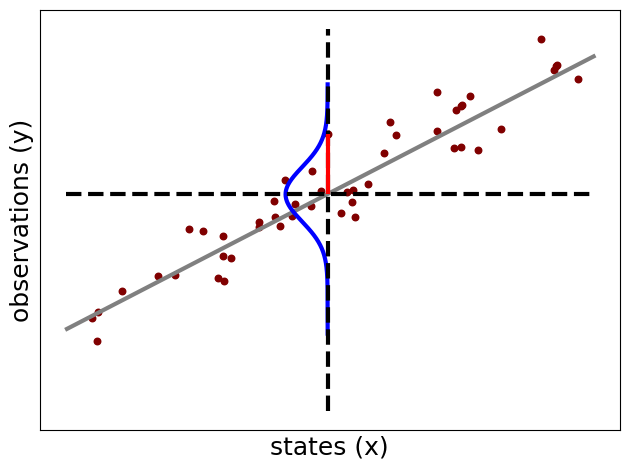

In [8]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Plot (1): Samples from probabilistic generative process
ax.scatter(states, data,
           s=22,
           c="maroon")

# Plot (2): Deterministic (linear) generating function
ax.plot(x_range.tolist(), [G(elem, beta_0=3, beta_1=2) for elem in x_range],
        c="gray",
        linewidth=3)

# Plot (3): Normal distribution around the sampled point
ax.plot(-norm_pdf + G_inv(y_mean, beta_0=3, beta_1=2), y_range,
        c="blue",
        linewidth=3)

# Plot (4): Boundary lines
ax.hlines(y=y_mean, xmin=0, xmax=5,
          linestyle="dashed",
          colors="black",
          linewidth=3)

ax.vlines(x=G_inv(y_mean, beta_0=3, beta_1=2),
          ymin=0, ymax=14,
          linestyle="dashed",
          colors="black",
          linewidth=3)

# Plot (5): Error/offset for the samples point
ax.vlines(x=G_inv(y_mean, beta_0=3, beta_1=2),
          ymin=point_y, ymax=y_mean,
          colors="red",
          linewidth=3)

# Axis labels and stylizing
ax.set_xlabel("states (x)", fontsize=18)
ax.set_ylabel("observations (y)", fontsize=18)
ax.tick_params(
    axis='both',
    which='both',
    bottom=False,
    left=False,
    labelbottom=False,
    labelleft=False)

fig.tight_layout()